Check 1D to 2D
===================

Sometimes we want to check the detector image corresponds to a point of the extracted spectrum.

The first part is the same as the usual reduction process before assign wavelength to the extracted spectrum.
See IRD_stream for more detail.

No fitsid yet.
h  band
median combine:  


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 530.90it/s]


cross-section: row  1170


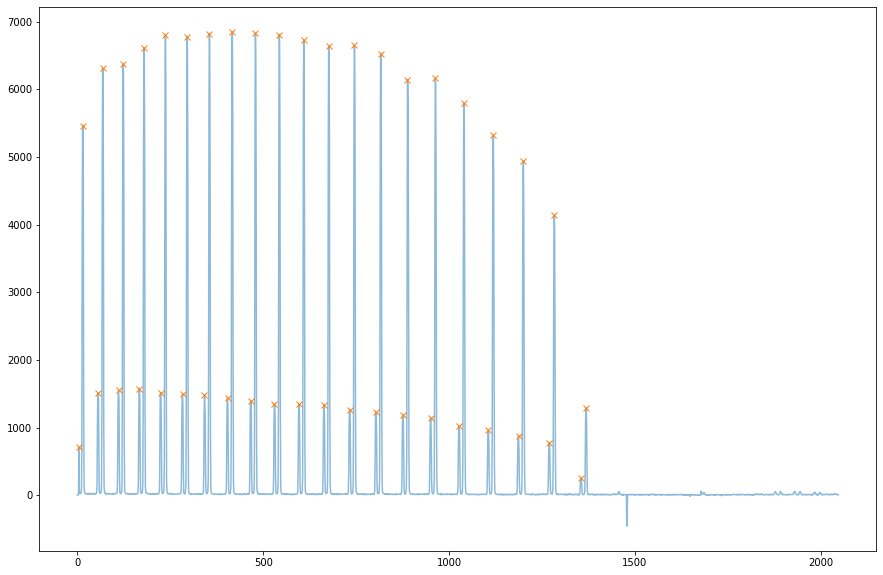

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:12<00:00,  3.46it/s]


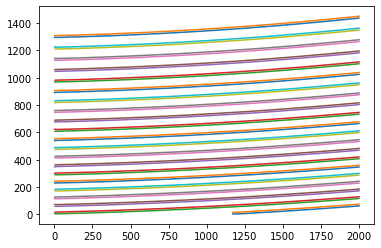

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 104.21it/s]


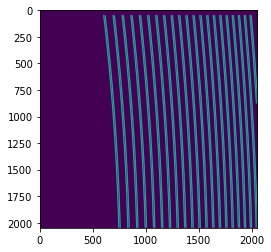

fitsid: [43814]
hotpix mask = 0.45 percent
fitsid: [14632, 14633, 14634, 14635, 14636, 14637, 14638, 14639, 14640, 14641, 14642, 14643, 14644, 14645, 14646, 14647, 14648, 14649, 14650, 14651, 14652, 14653, 14654, 14655, 14656, 14657, 14658, 14659, 14660, 14661, 14662, 14663, 14664, 14665, 14666, 14667, 14668, 14669, 14670, 14671, 14672, 14673, 14674, 14675, 14676, 14677, 14678, 14679, 14680, 14681, 14682, 14683, 14684, 14685, 14686, 14687, 14688, 14689, 14690, 14691, 14692, 14693, 14694, 14695, 14696, 14697, 14698, 14699, 14700, 14701, 14702, 14703, 14704, 14705, 14706, 14707, 14708, 14709, 14710, 14711, 14712, 14713, 14714, 14715, 14716, 14717, 14718, 14719, 14720, 14721, 14722, 14723, 14724, 14725, 14726, 14727, 14728, 14729, 14730, 14731]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 102.00it/s]


Skipped 100 files because they already exists.


0it [00:00, ?it/s]


median combine:  _cp


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1250.36it/s]
/Users/yuikasagi/miniforge3/envs/py39_pip/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


fitsid: [41510]
clean_pattern: output extension= _cp


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 105.77it/s]


Ignore  IRDA00041511.fits -> IRDA00041511_cp.fits


0it [00:00, ?it/s]


In [1]:
from pyird.utils import irdstream
import pathlib
from pyird.image.bias import bias_subtract_image
from pyird.image.hotpix import identify_hotpix_sigclip
import astropy.io.fits as pyf

# path
basedir = pathlib.Path('~/pyird/data/20210317/').expanduser()

### FOR CALIBRATION ###
# aperture extraction
datadir = basedir/'flat/'
anadir = basedir/'reduc/'
flat=irdstream.Stream2D("flat",datadir,anadir)
flat.fitsid=list(range(41704,41804,2)) ##FLAT_COMB

################################
### SELECT H band or YJ band ###
################################
flat.band='h' #'h' or 'y'
print(flat.band,' band')
if flat.band=='h':
    flat.fitsid_increment() # when you use H-band
    trace_mmf=flat.aptrace(cutrow = 800,nap=42) #TraceAperture instance
elif flat.band=='y':
    trace_mmf=flat.aptrace(cutrow = 1000,nap=102) #TraceAperture instance

import matplotlib.pyplot as plt
plt.imshow(trace_mmf.mask()) #apeture mask plot
plt.show()

# hotpixel mask
datadir = basedir/'dark/'
anadir = basedir/'reduc/'
dark = irdstream.Stream2D('dark', datadir, anadir,fitsid=[43814])
if flat.band=='h':
    dark.fitsid_increment() # when you use H-band
for data in dark.rawpath:
    im = pyf.open(str(data))[0].data
im_subbias = bias_subtract_image(im)
hotpix_mask = identify_hotpix_sigclip(im_subbias)

###########################
### SELECT mmf2 or mmf1 ###
###########################
trace_mmf.mmf2() #mmf2 (star fiber)
#trace_mmf.mmf1() #mmf1 (comb fiber)

# load ThAr raw image
datadir = basedir/'thar'
anadir = basedir/'reduc'
if flat.band=='h':
    rawtag='IRDAD000'
elif flat.band=='y':
    rawtag='IRDBD000'

#wavelength calibration
thar=irdstream.Stream2D("thar",datadir,anadir,rawtag=rawtag,fitsid=list(range(14632,14732)))
thar.trace = trace_mmf
thar.clean_pattern(extin='', extout='_cp', hotpix_mask=hotpix_mask)
thar.calibrate_wavelength()

### TARGET ###
# Load data
datadir = basedir/'target/'
anadir = basedir/'reduc/'
target = irdstream.Stream2D(
    'targets', datadir, anadir, fitsid=[41510])
if flat.band=='h':
    target.fitsid_increment() # when you use H-band
target.info = True  # show detailed info
target.trace = trace_mmf
# clean pattern
target.clean_pattern(extin='', extout='_cp', hotpix_mask=hotpix_mask)


The following is the process of displaying the figures.

You can set some parameters for plot(s). For example, you can get images for several orders.

In [2]:
import matplotlib
matplotlib.use('tkagg')
from pyird.utils.image_widget import image_1Dand2D
import tkinter as tk

### SET PARAMETERS ###
hotpix_mask = None # comment out this if you want to show hotpixels
target.imcomb = False # set 'True' if you want to median combine images.
wavcal_path = thar.anadir/('thar_%s_%s.fits'%(thar.band,thar.trace.mmf))

## additional parameters for plot
vmin = -10
vmax = 50
scale = 'linear' # 'linear' or 'log'
params = {'vmin':vmin,'vmax':vmax,'scale':scale}

orders=[10,12] # orders to be plotted
#######################

## Values needed for plotting
rsd,wav,mask,pixcoord,rotim,iys_plot,iye_plot = target.flatten_check(extin='_cp',wavcal_path=wavcal_path)

[PosixPath('/Users/yuikasagi/pyird/data/20210317/reduc/IRDA00041511_cp.fits')]
/Users/yuikasagi/pyird/data/20210317/reduc/IRDA00041511_cp.fits


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 46.10it/s]


`show_spec_to_image()` will create two figures in one window for each order.

* The upper figure is the spectrum of a order, and the lower figure is the detector image.
* You can zoom up both image.
* When you press any key on the spectrum, corresponding positions on the detector will be plotted as 'x'.

*!!! caution !!! If you run in jupyter notebook, add `%matplolib notebook` and comment out `root.mainloop()`*

In [3]:
## show 1d spectrum and 2d image
%matplotlib notebook
for order in orders:
    print(order)
    ## draw window
    root = tk.Tk()
    window = image_1Dand2D(root,order=order,band=flat.band)
    window.show_spec_to_image(rsd,wav,mask,pixcoord,rotim,iys_plot,iye_plot,wavcal_path=wavcal_path,hotpix_mask=hotpix_mask,**params)
#root.mainloop()

10


<IPython.core.display.Javascript object>

12


<IPython.core.display.Javascript object>

`show_emission_position()` will be useful for <u>the emission spectrum (e.g. sky spectrum)<u>.

* The upper figure is the detector image of one aperture, and the lower figure is the spectra of the order.
* By fitting 2D gaussian to the emissions on the detector, the emission like signal and hotpixels are distinguished automatically.

*!!! caution !!! If you run in jupyter notebook, add `%matplolib notebook` and comment out `root.mainloop()`*